In [10]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import graphviz
import json
from pandas.io.json import json_normalize

In [2]:
def cleanData(filePath, filePathJson, encoding):
    data = pd.read_csv(filePath, encoding=encoding)
    data['trending_date'] = '20' + data['trending_date']
    data['trending_date'] = pd.to_datetime(data['trending_date'],format='%Y.%d.%m')
    data['publish_time'] = data['publish_time'].replace(regex=True,to_replace=r"T.*",value=r'')
    data['publish_time'] = pd.to_datetime(data['publish_time'],format='%Y-%m-%d', errors='coerce')
    categories = pd.read_json(filePathJson)
    catData = json_normalize(categories['items'])
    idToCategories = pd.DataFrame(columns=['category_id', 'category'])
    idToCategories['category_id'] = catData['id']
    idToCategories['category'] = catData['snippet.title']
    idToCategories['category_id'] = idToCategories['category_id'].astype('int64')
    myData = pd.merge(data, idToCategories)
    myData = myData.drop(columns='category_id')
    myData['tags'] = myData.tags.str.strip().str.lower().str.replace('"','').str.replace('|',',')
    myData = myData.drop_duplicates()
    return myData

def allParcableCountryData():
    us = cleanData('../Data/Youtube/USvideos.csv', '../Data/Youtube/US_category_id.json', "latin_1")
    mx=  cleanData('../Data/Youtube/MXvideos.csv', '../Data/Youtube/MX_category_id.json', "latin_1")
    ca=  cleanData('../Data/Youtube/CAvideos.csv', '../Data/Youtube/CA_category_id.json', "latin_1")
    de=  cleanData('../Data/Youtube/DEvideos.csv', '../Data/Youtube/DE_category_id.json', "latin_1")
    gb=  cleanData('../Data/Youtube/GBvideos.csv', '../Data/Youtube/GB_category_id.json', "latin_1")
    ind= cleanData('../Data/Youtube/INvideos.csv', '../Data/Youtube/IN_category_id.json', "latin_1")
    fr=  cleanData('../Data/Youtube/FRvideos.csv', '../Data/Youtube/FR_category_id.json', "latin_1")
    us["country"] = "us"
    mx["country"] = "mx"
    ca["country"] = "ca"
    de["country"] = "de"
    gb["country"] = "gb"
    ind["country"] = "in"
    fr["country"] = "fr"
    data = us.append([mx,ca,de,gb,ind,fr])
    return data

In [3]:
allData = allParcableCountryData()

In [4]:
groupedData = allData.groupby('country')

Text(0.5, 1.0, 'Number of views by country')

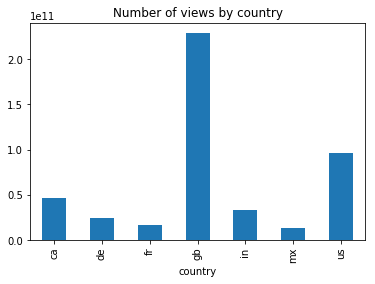

In [5]:
groupedData.views.sum().plot.bar()
plt.title('Number of views by country')

Text(0.5, 1.0, 'Number of likes by country')

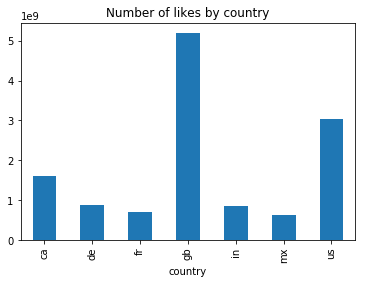

In [6]:
groupedData.likes.sum().plot.bar()
plt.title('Number of likes by country')

Text(0.5, 1.0, 'Number of dislikes by country')

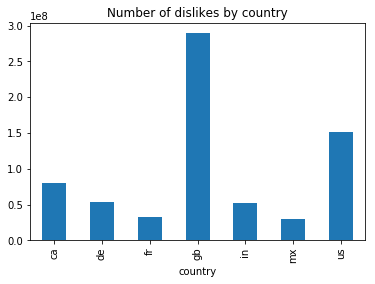

In [7]:
groupedData.dislikes.sum().plot.bar()
plt.title('Number of dislikes by country')

Text(0.5, 1.0, 'Number of entries by country')

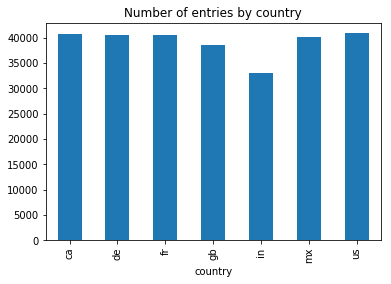

In [8]:
groupedData.count().title.plot.bar()
plt.title('Number of entries by country')

Text(0.5, 1.0, 'Number of comment count by country')

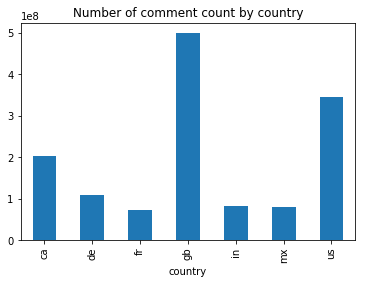

In [9]:
groupedData.comment_count.sum().plot.bar()
plt.title('Number of comment count by country')

In [12]:
allData['trending'] = pd.qcut(allData.views,q=2,labels=['Not Trending','Trending'])
allData.head(1)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category,country,trending
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,2017-11-13,shantell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs,us,Trending


In [20]:
attributes = allData.drop(['channel_title','views','likes','dislikes','comment_count','trending','video_id','thumbnail_link','trending_date','publish_time','description','country'],axis=1)

In [21]:
attributes.title = [len(title.split()) for title in attributes.title]

In [22]:
attributes.tags = [len(tag.split()) for tag in attributes.tags]

In [23]:
attributes = pd.get_dummies(attributes)

In [24]:
attributes.head(4)

,title,tags,comments_disabled,ratings_disabled,video_error_or_removed,category_Autos & Vehicles,category_Comedy,category_Education,category_Entertainment,category_Film & Animation,...,category_Music,category_News & Politics,category_Nonprofits & Activism,category_People & Blogs,category_Pets & Animals,category_Science & Technology,category_Shows,category_Sports,category_Trailers,category_Travel & Events
0,7,2,False,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3,1,False,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,13,24,False,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,10,1,False,False,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [25]:
target = allData.trending
target.head(2)

0        Trending
1    Not Trending
Name: trending, dtype: category
Categories (2, object): [Not Trending < Trending]

In [26]:
target.value_counts()

Not Trending    137348
Trending        137345
Name: trending, dtype: int64

In [27]:
NBayes = MultinomialNB()

In [56]:
parameters={'alpha':range(1,15)}

In [57]:
NBayesCV = GridSearchCV(NBayes, param_grid=parameters)

In [58]:
NBayesCV.fit(attributes,target)

C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': range(10, 60)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

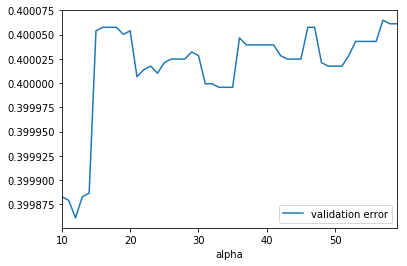

In [59]:
error = pd.DataFrame()
error['alpha'] = parameters['alpha']
error['validation error'] = 1 - NBayesCV.cv_results_['mean_test_score']
error.plot.line(x='alpha',y='validation error')

In [60]:
NBayesCV.best_params_

{'alpha': 12}

In [61]:
NBayesCV.best_score_

0.6001390643372784

In [62]:
error_rate = 1 - NBayesCV.best_score_
print('Naive Bayes error rate is ', error_rate.round(2))

Naive Bayes error rate is  0.4


In [41]:
Tree = tree.DecisionTreeClassifier()

In [49]:
parameters = {'max_depth':range(27,50)} # define a dictionary

In [50]:
TreeCV = GridSearchCV(Tree,param_grid=parameters,return_train_score=True) # cross validation

In [51]:
TreeCV.fit(attributes,target)

C:\Users\alawamhm\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(27, 50)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

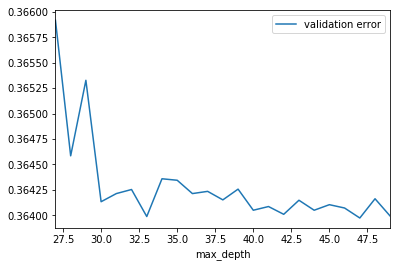

In [52]:
error = pd.DataFrame()
error['max_depth'] = parameters['max_depth']
error['validation error'] = 1 - TreeCV.cv_results_['mean_test_score']
error.plot.line(x='max_depth',y='validation error')

In [53]:
TreeCV.best_params_

{'max_depth': 47}

In [54]:
TreeCV.best_score_

0.6360264003815168

In [55]:
error_rate = 1 - TreeCV.best_score_
print('Decision Tree classifaier error rate is ', error_rate.round(2))

Decision Tree classifaier error rate is  0.36
